# Library

In [1]:
import numpy as np
import math
import os
import sys
import scipy
from scipy.signal import argrelextrema, correlate2d
from scipy.misc import imresize
from scipy import ndimage
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

# Some Functions 

In [2]:
def rgb2gray(img):
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

#  Data Loading

In [8]:
# Loading Image & Error
cwd = os.getcwd()
dataDir = "/data/full/"
cats = os.listdir(cwd + dataDir)
anns = {}

cnt = 0
for c in cats :
    for name in os.listdir(cwd + dataDir + c):
        img = ndimage.imread(cwd + dataDir + c + "/" + name).astype(float)
        anns[name] = {'img':img, 'cat':c}
            
f = open(cwd + "/data/file_list.txt", 'r')
errLines = f.readlines()
for l in errLines :
    tokens = l.split(':')[-2:]
    c, name = tokens[0].split('\\')[-2:]
    if name in anns :
        err = tokens[1][:-2].replace(')','').replace('(','').split(',')
        if len(err) > 1 :
            anns[name]['err'] = map(int, err)
        else :
            anns[name]['err'] = []

In [11]:
cats = os.listdir(cwd + dataDir)
c = cats[0]
print os.listdir(cwd + dataDir + c)

['A2MR1S71NHOA4.A2MR1S71NHOAC074.000_20170129122604_O_R180_CROP.bmp', 'A2MR1S71NHQA6.A2MR1S71NHQCC124.008_20170129123624_O_CROP.bmp', 'A2MR1S71NHQA6.A2MR1S71NHQBD067.044_20170129123719_O_HFS_CROP.bmp', 'A2MR1S71MWFA9.A2MR1S71MWFBB024.054_20170131005844_O_CROP.bmp', 'A2MR1S71NFLA9.A2MR1S71NFLBC025.038_20170130034646.jpg', 'A2MR1S71NHOA4.A2MR1S71NHOCA131.012_20170129122620_O_CROP.bmp', 'A2MR1S71MWQA0.A2MR1S71MWQCD152.034_20170131015411_O_R180_CROP.bmp', 'A2MR1S71NFDA1.A2MR1S71NFDCD164.018_20170130025638_O_CROP.bmp', 'A2MR1S71NHQA6.A2MR1S71NHQBB010.049_20170129123727_O_R180S_CROP.bmp', 'A2MR1S71MWBA5.A2MR1S71MWBDB112.043_20170131003832_O_R180S_CROP.bmp', 'A2MR1S71MWSA2.A2MR1S71MWSDC154.025_20170131020412_O_HF_CROP.bmp', 'A2MR1S71NCOA9.A2MR1S71NCOBB013.044_20170129170653_O_VFS_CROP.bmp', 'A2MR1S71MWBA5.A2MR1S71MWBDB112.043_20170131003832_O_HF_CROP.bmp', 'A2MR1S71MW2A9.A2MR1S71MW2BD059.043_20170130235204_O_VFS_CROP.bmp', 'A2MR1S71MWDA7.A2MR1S71MWDDB103.034_20170131004824_O_VFS_CROP.bmp', 'A

In [13]:
# Collect CNN Input Data
catList = [None]*len(anns)
for i, a in enumerate(anns.values()) :
    catList[i] = a['cat']
catList = list(set(catList))

catDic = {}
for i in range(len(catList)) :
    catDic[catList[i]] = i
catDic['NORMAL'] = i+1

In [14]:
print catDic

{'ACT_HABU_PTN_ER': 0, 'SHORT_D': 1, 'CNT_FILM': 7, 'SD_SPOT': 3, 'HOLE_PTN_ERR': 4, 'NORMAL': 12, 'GAT2_HABU_PTN_E': 11, 'CNT_NOT_OPEN_S': 5, 'SD_BOMB': 6, 'BLACK_SPOT': 8, 'CNT_NOT_OPEN': 2, 'PASS': 10, 'GAT1_HABU_PTN_E': 9}


# RGB to Gray 

In [17]:
for a in anns.values() :
    a['img_gray'] = rgb2gray(a['img'])

# Autocorelation 

In [18]:
tempX = 138
tempY = 270
resizeX = 140
resizeY = 280

X = tf.placeholder(tf.float32, name="Image")
t = tf.placeholder(tf.float32, name="Template")
conv = tf.nn.conv2d(X, t, strides=[1,1,1,1], padding='VALID')

init = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))
sess.run(init)

In [19]:
# calculate correlation
corr = []

for a in anns.values() :
    img = a['img_gray']
    img = img.reshape(-1, img.shape[0], img.shape[1], 1)
    template = img[:, :tempY, :tempX, :].reshape(tempY,tempX,1,1)
    corr_o = sess.run(conv, feed_dict={X:img, t:template})
    a['corr'] = corr_o.reshape(corr_o.shape[1], corr_o.shape[2])

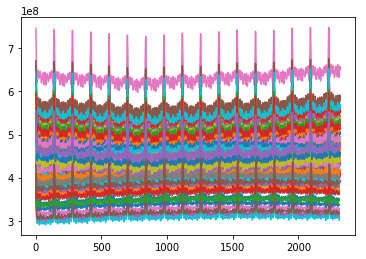

In [20]:
# infer slice index
for a in anns.values() :
    horCorr = a['corr'][0,:]
    verCorr = a['corr'][:,0]
    plt.plot(horCorr)
    horIdx = []
    verIdx = []
    for i in range(horCorr.size/tempX):
        horIdx.append(i*tempX + np.argmax(horCorr[i*tempX:(i+1)*tempX]))
    horIdx.append((i+1)*tempX + np.argmax(horCorr[(i+1)*tempX:]))
    for i in range(verCorr.size/tempY):
        verIdx.append(i*tempY + np.argmax(verCorr[i*tempY:(i+1)*tempY]))
    verIdx.append((i+1)*tempY + np.argmax(verCorr[(i+1)*tempY:]))
    a['slcX'] = horIdx
    a['slcY'] = verIdx

# Image Slicing 

In [56]:
slcNumX = len(anns.values()[0]['slcX'])-1
slcNumY = len(anns.values()[0]['slcY'])-1
for a in anns.values() :
    img_gray = a['img_gray']
    img = a['img']
    slc_gray = [ [x for x in range(slcNumX)] for y in range(slcNumY) ]
    slc = [ [x for x in range(slcNumX)] for y in range(slcNumY) ]
    horIdx = a['slcX']
    verIdx = a['slcY']
    for j in range(slcNumY):
        for k in range(slcNumX):
            currSlc_gray = imresize(img_gray[verIdx[j]:verIdx[j+1], horIdx[k]:horIdx[k+1]], (resizeY, resizeX), mode='F')
            slc_gray[j][k] = currSlc_gray
            currSlc = imresize(img[verIdx[j]:verIdx[j+1], horIdx[k]:horIdx[k+1],:], (resizeY, resizeX, 3))
            slc[j][k] = currSlc
    a['slc_gray'] = slc_gray
    a['slc'] = slc

In [23]:
# Find Error Slices
for a in anns.values() :
    slc = []
    if 'err' in a.keys() :
        e = a['err']#.replace(')','').replace('(','').split(',')
    else :
        e = []
    a['is_err'] = np.zeros((slcNumY, slcNumX))
    if len(e) > 0 :
        for j in range(len(e)/2) :
            offsetX = int(e[2*j])/tempX
            offsetY = int(e[2*j+1])/tempY
            if offsetX < slcNumX and offsetY < slcNumY :
                a['is_err'][offsetY, offsetX] = 1

# Compare 

In [80]:
# subtract by average slice
for a in anns.values() :
    slcCompAvg = [ [x for x in range(slcNumX)] for y in range(slcNumY) ]
    slc = a['slc']
    is_err = a['is_err']
    baseSlc = 0
    cnt = 0
    for i in range(slcNumY) :
        for j in range(slcNumX) :
            if is_err[i][j] == 0 :
                baseSlc += slc[i][j]
                cnt += 1
    baseSlc = baseSlc/cnt
    # baseImg = imageCrop[0].astype(int)
    for i in range(slcNumY):
        for j in range(slcNumX):
#             if is_err[i][j] == 0 :
            slcCompAvg[i][j] = abs(slc[i][j] - baseSlc)
#             else :
#                 slcCompAvg[i][j] = np.zeros((resizeY, resizeX))
    a['slcCompAvg'] = slcCompAvg

In [ ]:
# visualize
idx = np.random.randint(len(anns))
a = anns.values()[idx]
is_err = a['is_err']
slcCompAvg = a['slcCompAvg']
fig, ax = plt.subplots(slcNumY, slcNumX, figsize=(20,20))
for i in range(slcNumY):
    for j in range(slcNumX):
        if is_err[i][j] == 0 :
            try :
                ax[i,j].imshow(slcCompAvg[i][j], vmin=0, vmax=255, cmap='gray_r')
            except :
                print i, j, is_err
#         else :
#             slcCompAvg[i][j] = -1
        ax[i,j].axis('off')
        
# plt.savefig('compareGrayAvg_resize.png')
# print np.max(abs(currImg - baseImg))/255

In [ ]:
# 이미지별 슬라이스 평균 오차 최대최소 & 대표값
import seaborn as sns
sns.set(color_codes=True)
# slcComp = []
maxErrs = np.zeros((len(anns),1))
secErrs = np.zeros((len(anns),1))
minErrs = np.zeros((len(anns),1))
meanErrs = np.zeros((len(anns),1))
for i, a in enumerate(anns.values()) :
    mean = np.average(abs(np.array(a['slcCompAvg'])), axis=(2,3))
    maxErrs[i] = np.max(mean)
    secErrs[i] = np.partition(mean.ravel(), -2)[-2]
    mean[mean==0] = np.average(mean[mean>0])
    minErrs[i] = np.min(mean)
    meanErrs[i] = np.average(mean[mean>0])
    
# errSlcs = np.average(abs(np.array(compSlcs)), axis=(2,3))
# print maxErrSlcs
# print secErrSlcs
plt.figure(1)
sns.distplot(maxErrs, kde=False, label="FirstMax")
sns.distplot(secErrs, kde=False, label="SecondMax")
# sns.distplot(minErrSlcs)
print np.average(maxErrs)
print np.average(secErrs)
# plt.figure(2)
sns.distplot(minErrs, kde=False, label="Min")
print np.average(minErrs)
plt.xlim([0, 30])
plt.legend()
plt.savefig("SliceAvgErr_MaxMin4.jpg")

plt.figure(2)
sns.distplot(meanErrs, kde=False, label="Average")
# plt.xlim([4.5, 8.5])
plt.legend()
print np.average(meanErrs)
plt.savefig("SliceAvgErr_Avg4.jpg")

# Make Data for CNN

In [84]:
X = []
y = []
for a in anns.values() :
    if len(a['err']) > 0 :
        is_err = a['is_err']
        
        loc_one = np.where(is_err==1)
        idx = np.random.randint(len(loc_one[0]))
        X.append(a['slcCompAvg'][loc_one[0][idx]][loc_one[1][idx]])
        y.append(catDic[a['cat']])
        
        n_normal = 1
        loc_zero = np.where(is_err==0)
        idx = np.random.permutation(len(loc_zero[0]))[:n_normal]
        for i in range(n_normal) :
            X.append(a['slcCompAvg'][loc_zero[0][idx[i]]][loc_zero[1][idx[i]]])
            y.append(catDic['NORMAL'])

# Save Data for CNN 

In [85]:
# save slices subtracted by average slice
import pickle
Data = {'X':X, 'y':y}
with open(os.getcwd() + "/data/sample/SampleData_Normal1.pkl", 'wb') as f :
    pickle.dump(Data, f, pickle.HIGHEST_PROTOCOL)